In [1]:
import xarray as xr
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import cartopy.crs as ccrs
import scipy.stats

from deepmip_dict import deepmip_dict

data_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/aprp_output_data/'
cmip_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/data/cmip6/'
deepmip_dir = '/Users/wb19586/Documents/data/deepmip_database/deepmip-eocene-p1/'

In [2]:
# get DeepMIP data
deepmip_gmsts = {}
deepmip_ecs = {}
deepmip_cld = {}

for model in deepmip_dict.keys():
    for i in range(deepmip_dict[model]['ncase']-1):

        if deepmip_dict[model]['contr'][i] == 'deepmip-eocene-p1-PI':
            continue
            
        aprp_file = model + '.' + deepmip_dict[model]['contr'][i] +'.to.' + deepmip_dict[model]['sensi'][i] + '.aprp.nc'
        aprp      = xr.open_dataset(data_dir + '/deepmip/' + aprp_file, decode_times=False)
        aprp = aprp.where(aprp <= 1e6, np.nan)
        aprp_ym   = aprp.mean('time')

        # get area weights
        coslat     = np.cos(np.deg2rad(aprp.lat))

        # calculate GMSTs and ECS
        gmst1     = aprp_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
        gmst2     = aprp_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
        dT        = (gmst2 - gmst1).values

        # get CO2 levels from experiment name
        if ( deepmip_dict[model]['contr'][i] != "deepmip-eocene-p1-x1.5" ):
            co2_low  = int(deepmip_dict[model]['contr'][i][-1]) * 280
        else:
            co2_low  = 1.5 * 280
        co2_high = int(deepmip_dict[model]['sensi'][i][-1]) * 280

        # ECS = dT x (ln(2)/ln(c2/c1))
        ecs = dT * ( math.log(2) / math.log( co2_high / co2_low ) )

        # global mean cloud feedback
        cld_feedback_gm = aprp_ym['cld'].weighted(coslat).mean(('lat','lon')) / dT

        deepmip_gmsts[f"{model}_{deepmip_dict[model]['contr'][i]}"] = gmst1
        deepmip_ecs[f"{model}_{deepmip_dict[model]['contr'][i]}"] = ecs
        deepmip_cld[f"{model}_{deepmip_dict[model]['contr'][i]}"] = cld_feedback_gm

        

print(deepmip_ecs)


{'CESM1.2-CAM5_deepmip-eocene-p1-x1': 4.184434412701716, 'CESM1.2-CAM5_deepmip-eocene-p1-x3': 4.776824951171875, 'CESM1.2-CAM5_deepmip-eocene-p1-x6': 9.743504846739595, 'GFDL-CM2.1_deepmip-eocene-p1-x1': 3.678985595703125, 'GFDL-CM2.1_deepmip-eocene-p1-x2': 4.577178955078125, 'GFDL-CM2.1_deepmip-eocene-p1-x3': 4.8565673828125, 'GFDL-CM2.1_deepmip-eocene-p1-x4': 4.678827229417843, 'HadCM3B-M2.1aN_deepmip-eocene-p1-x1': 3.76531982421875, 'HadCM3B-M2.1aN_deepmip-eocene-p1-x2': 6.577559634469607, 'IPSLCM5A2_deepmip-eocene-p1-x1.5': 5.55279541015625, 'MIROC4m_deepmip-eocene-p1-x1': 3.867828369140625, 'MIROC4m_deepmip-eocene-p1-x2': 5.202458968654127, 'NorESM1-F_deepmip-eocene-p1-x2': 2.857269287109375}


/Users/wb19586/opt/anaconda3/envs/aprp/lib/python3.9/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/wb19586/opt/anaconda3/envs/aprp/lib/python3.9/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/wb19586/opt/anaconda3/envs/aprp/lib/python3.9/site-packages/xarray/coding/times

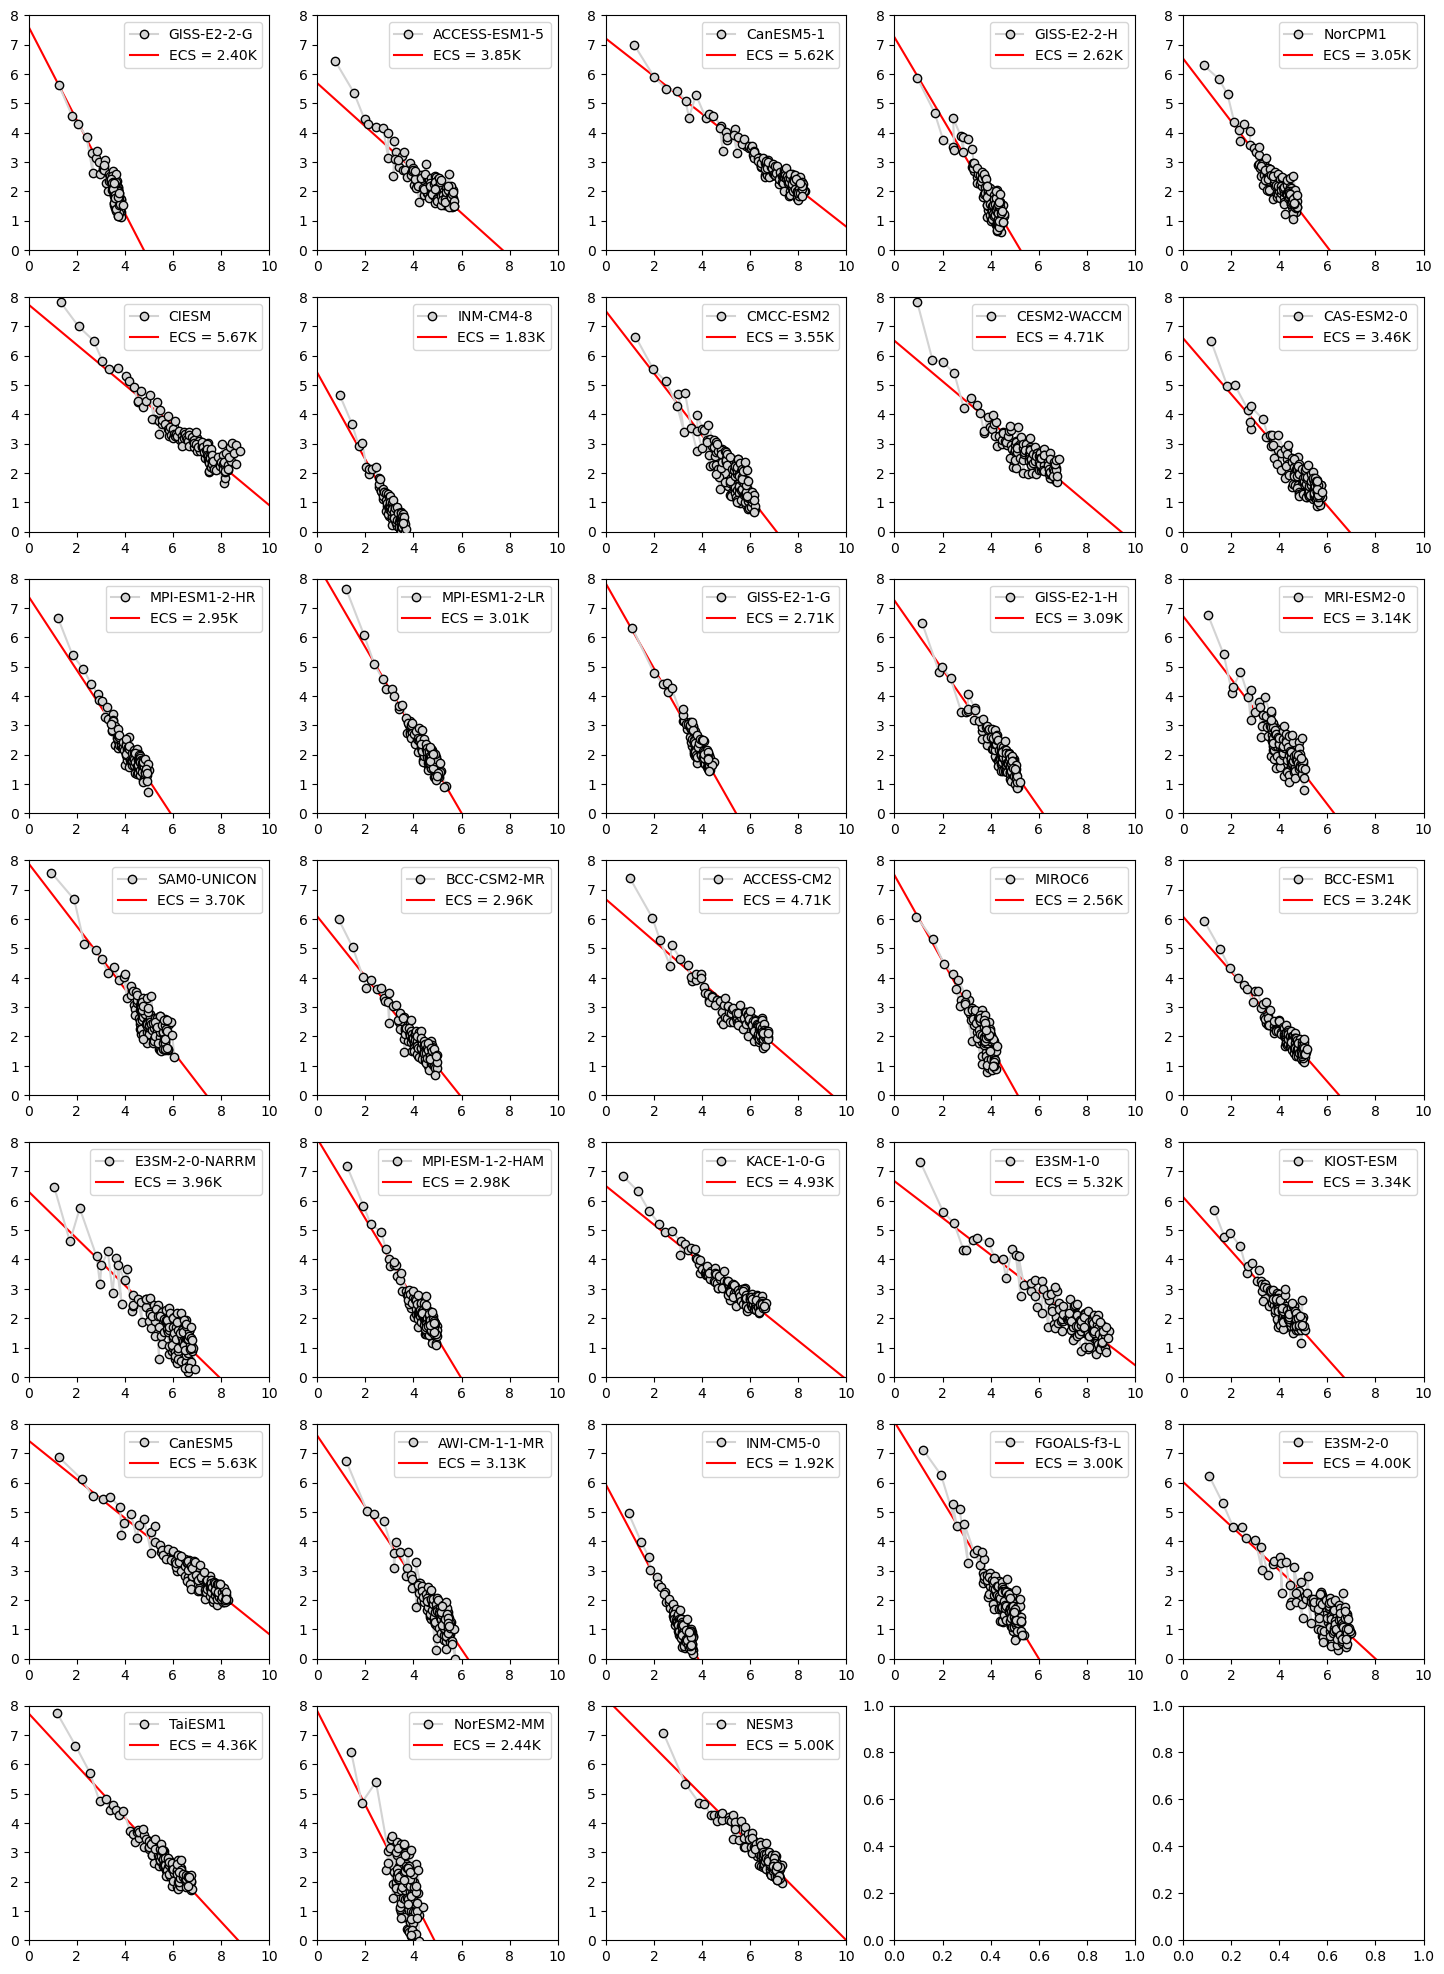

In [3]:
# get CMIP6 data
cmip_gmsts = []
cmip_cld = []
cmip_ecs = []

# Gregory plots
num_cols = 5
plot_idx = 0
row_idx = 0
col_idx = 0
fig, axs = plt.subplots(7, 5, figsize=(18, 25))

for model in os.listdir(cmip_dir + "piControl/"):

    if model == '.DS_Store' or model == 'IPSL-CM6A-LR' or model == 'CMCC-CM2-SR5' or model == 'FGOALS-g3':
        continue
    
    aprp_file = model + '.piControl.to.abrupt-4xCO2.aprp.nc'
    aprp      = xr.open_dataset(data_dir + '/cmip/' + aprp_file, decode_times=False)
    aprp = aprp.where(aprp <= 1e6, np.nan)
    aprp_ym   = aprp.mean('time')

    # calculate area weights
    coslat     = np.cos(np.deg2rad(aprp.lat))
    
    gmst1     = aprp_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT        = (gmst2 - gmst1).values

    cmip_gmsts.append(gmst1.values)

    # global mean cloud feedback
    cld_feedback_gm = aprp_ym['cld'].weighted(coslat).mean(('lat','lon')) / dT
    # cmip_cld[f"cmip_{model}"] = cld_feedback_gm
    cmip_cld.append(cld_feedback_gm.values)

    # claclulate ECS via Gregory plots
    # PI reference
    tas_clim = xr.open_dataset(cmip_dir + '/piControl/' + model + "/tas_climatology.nc", decode_times=False)["tas"].squeeze()
    rlut_clim = xr.open_dataset(cmip_dir + '/piControl/' + model + "/rlut_climatology.nc", decode_times=False)["rlut"].squeeze()
    rsut_clim = xr.open_dataset(cmip_dir + '/piControl/' + model + "/rsut_climatology.nc", decode_times=False)["rsut"].squeeze()
    rsdt_clim = xr.open_dataset(cmip_dir + '/piControl/' + model + "/rsdt_climatology.nc", decode_times=False)["rsdt"].squeeze()

    toa_clim = rsdt_clim - rsut_clim - rlut_clim
    
    coslat = np.cos(np.deg2rad(tas_clim.lat))
    
    tas_mean = tas_clim.mean('time').weighted(coslat).mean(('lat','lon'))
    toa_mean = toa_clim.mean('time').weighted(coslat).mean(('lat','lon'))

    tas_gm_ts = xr.open_dataset(cmip_dir + '/abrupt-4xCO2/' + model + "/tas_gm.ts.nc", decode_times=False)["tas"].squeeze()
    toa_gm_ts = xr.open_dataset(cmip_dir + '/abrupt-4xCO2/' + model + "/toa-balance_gm.ts.nc", decode_times=False)["rsdt"].squeeze()

    tas_anom = tas_gm_ts - tas_mean
    toa_anom = toa_gm_ts - toa_mean

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(tas_anom, toa_anom)

    # Calculate ECS and store it
    ecs = -intercept / slope / 2.0 if slope != 0 else np.nan
    # cmip_ecs[f"cmip_{model}"] = ecs
    cmip_ecs.append(ecs)

    # Plotting the regression line
    # Create a range of x-values from 0 to 10
    x_values = np.linspace(0, 10, 100)

    # Create a legend label with the model name and ECS value

    axs[row_idx,col_idx].plot(tas_anom, toa_anom, marker="o", markersize=6, markeredgecolor='k', color='lightgray', label=model,zorder=100)
    legend_label = f"ECS = {ecs:.2f}K"
    axs[row_idx, col_idx].plot(x_values, intercept + slope * x_values, 'r', label=legend_label)

    axs[row_idx,col_idx].legend()
    axs[row_idx,col_idx].set_xlim([0, 10])
    axs[row_idx,col_idx].set_ylim([0, 8])
    
    col_idx += 1

    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0


Text(0, 0.5, 'ECS [K]')

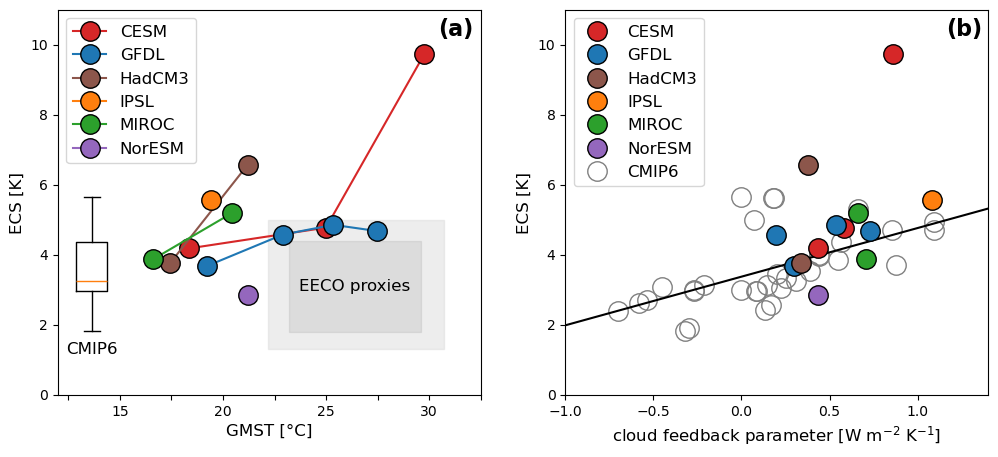

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for model in deepmip_dict.keys():
    model_gmsts = []
    for key, data_array in deepmip_gmsts.items():
        if key.startswith(model):
            model_gmsts.append(data_array.item())
    model_ecs = []
    for key, data_array in deepmip_ecs.items():
        if key.startswith(model):
            model_ecs.append(data_array.item())  
    model_cld = []
    for key, data_array in deepmip_cld.items():
        if key.startswith(model):
            model_cld.append(data_array.item())

    axs[0].plot(model_gmsts, model_ecs, marker="o", markersize=14, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)
    axs[1].plot(model_cld, model_ecs, marker="o", markersize=14, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100, linestyle='none')
    
axs[0].boxplot(cmip_ecs, positions=[np.mean(cmip_gmsts)], widths=1.5)
axs[0].set_xlim([12.0, 32.5])
axs[0].set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])
axs[0].set_ylim([0, 11])

axs[1].plot(cmip_cld, cmip_ecs, marker="o", markersize=14, markeredgecolor='gray', color='none', linestyle='none',zorder=1, label='CMIP6')
axs[1].set_xlim([-1.0, 1.4])
axs[1].set_ylim([0, 11])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(cmip_cld, cmip_ecs)

# Plotting the regression line
# Create a range of x-values from 0 to 10
x_values = np.linspace(-2, 2, 100)
# legend_label = f"ECS = {ecs:.2f}K"
axs[1].plot(x_values, intercept + slope * x_values, 'k',zorder=1)

# add GMST and ECS EECO estimates from Inglis et al. (2021)
gmst_min_90 = 22.2
gmst_max_90 = 30.7
ecs_min_90 = 1.3
ecs_max_90 = 5.0

gmst_min_66 = 23.2
gmst_max_66 = 29.6
ecs_min_66 = 1.8
ecs_max_66 = 4.4

inglis_90 = Rectangle((gmst_min_90, ecs_min_90), gmst_max_90-gmst_min_90, ecs_max_90-ecs_min_90, color='lightgray', alpha=0.4)
inglis_66 = Rectangle((gmst_min_66, ecs_min_66), gmst_max_66-gmst_min_66, ecs_max_66-ecs_min_66, color='gray', alpha=0.15)

# Add the rectangle to the plot
axs[0].add_patch(inglis_90)
axs[0].add_patch(inglis_66)
# Add text to the center of the rectangle
axs[0].text(gmst_min_66+(gmst_max_66-gmst_min_66)/2, ecs_min_66+(ecs_max_66-ecs_min_66)/2, 'EECO proxies', ha='center', va='center', fontsize=12)
axs[0].text(np.mean(cmip_gmsts), 1.3, 'CMIP6', ha='center', va='center', fontsize=12)

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)
axs[0].text(0.9, 0.98, '(a)', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top')
axs[1].text(0.9, 0.98, '(b)', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top')
axs[0].set_xlabel('GMST [°C]', fontsize=12)
axs[0].set_ylabel('ECS [K]', fontsize=12)
axs[1].set_xlabel('cloud feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=12)
axs[1].set_ylabel('ECS [K]', fontsize=12)
